## 2. Реализация модели

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def simulate(mean_arrival_rate, mean_departure_rate, number_of_servers, end_time):
    timeline = []
    active_servers = 0
    current_time = np.random.exponential(mean_arrival_rate)
    while current_time <= end_time:
        timeline.append({'event': 'arrival', 'served': None, 'time': current_time, 'active_servers': 0, 'time_in_state': 0})
        current_time += np.random.exponential(mean_arrival_rate)
    current_time = 0
    for point in timeline:
        current_time = point['time']
        if point['event'] == 'arrival':
            if active_servers < number_of_servers:
                point['served'] = True
                active_servers+=1
                point['active_servers'] = active_servers
                departure_point = {'event': 'departure', 'time': current_time+np.random.exponential(mean_departure_rate), 'time_in_state': 0}
                for i in range(len(timeline)-1, -1, -1):
                    if timeline[i]['time'] < departure_point['time']:
                        timeline.insert(i+1, departure_point)
                        break
            else:
                point['served'] = False
        elif point['event'] == 'departure':
            active_servers-=1
            point['active_servers'] = active_servers
    for i in range(len(timeline)-1):
        timeline[i]['time_in_state'] = timeline[i+1]['time'] - timeline[i]['time'] 
    return timeline

In [3]:
def stationary_probabilities(timeline, num_servers):
    states_time = [0 for i in range(num_servers+1)]
    for event in timeline:
        states_time[event['active_servers']]+=event['time_in_state']
    return [states_time[i]/res[-1]['time'] for i in range(len(states_time))]

In [4]:
def reject_probability(timeline):
    arrivals = [event for event in timeline if event['event']=='arrival']
    rejected = [arrival for arrival in arrivals if arrival['served']==False]
    return len(rejected)/len(arrivals)

In [5]:
def relative_bandwith(timeline):
    return 1 - reject_probability(timeline)

In [6]:
def absolute_bandwith(timeline):
    arrivals = [event for event in timeline if event['event']=='arrival']
    served = [arrival for arrival in arrivals if arrival['served']==True]
    return len(served)/timeline[-1]['time']

In [7]:
def average_load(timeline, mu_):
    return absolute_bandwith(timeline)/mu_

In [8]:
def downtime_probability(timeline):
    no_clients = [event for event in timeline if event['active_servers']==0]
    downtime = sum([event['time_in_state'] for event in no_clients])
    return downtime/timeline[-1]['time']

In [125]:
def draw_load_plot(arrival_rate, departure_rate, servers, end_time=250):
    timeline = simulate(arrival_rate, departure_rate, servers, end_time)
    plt.figure(figsize=(20,5))
    plt.grid()
    plt.axis([0, end_time, 0, servers])
    plt.title(label="График загруженности серверов при lambda={}, mu={}, {} servers".format(np.round(1/arrival_rate, 2), np.round(1/departure_rate, 2), servers))
    ax = [point['time'] for point in timeline]
    ax.insert(0, 0)
    ay = [point['active_servers'] for point in timeline]
    ay.insert(0, 0)
    plt.plot(ax, ay)
    plt.show()

In [91]:
def draw_rejection_plot(mean_departure_rate, servers):
    mean_arrival_rate = list(range(1,30))
    lambda_ = [1/x for x in mean_arrival_rate]
    rejection_probabilities = []
    for x in mean_arrival_rate:
        res = simulate(x, mean_departure_rate, servers, 10000)
        rejection_probabilities.append(reject_probability(res))
    plt.title(label='График роста вероятности отказа с ростом lambda; mu={}, {} servers'.format(1/mean_departure_rate, servers))
    plt.plot(lambda_, rejection_probabilities)
    plt.show()

In [93]:
def draw_rel_bandwith_plot(mean_departure_rate, servers):
    mean_arrival_rate = list(range(1,30))
    lambda_ = [1/x for x in mean_arrival_rate]
    rel_bandwiths = []
    for x in mean_arrival_rate:
        res = simulate(x, mean_departure_rate, servers, 10000)
        rel_bandwiths.append(relative_bandwith(res))
    plt.title(label='График падения относительной пропускной способности с ростом lambda; mu={}, {} servers'.format(1/mean_departure_rate, servers))
    plt.plot(lambda_, rel_bandwiths)
    plt.show()

In [103]:
def draw_downtime_plot(mean_departure_rate, servers):
    mean_arrival_rate = list(range(10,30))
    lambda_ = [1/x for x in mean_arrival_rate]
    downtime = []
    for x in mean_arrival_rate:
        res = simulate(x, mean_departure_rate, servers, 10000)
        downtime.append(relative_bandwith(res))
    plt.title(label='График падения относительной пропускной способности с ростом lambda; mu={}, {} servers'.format(1/mean_departure_rate, servers))
    plt.plot(lambda_, downtime)
    plt.show()

## 3. Эксперимент

### 1. $\lambda<\mu$

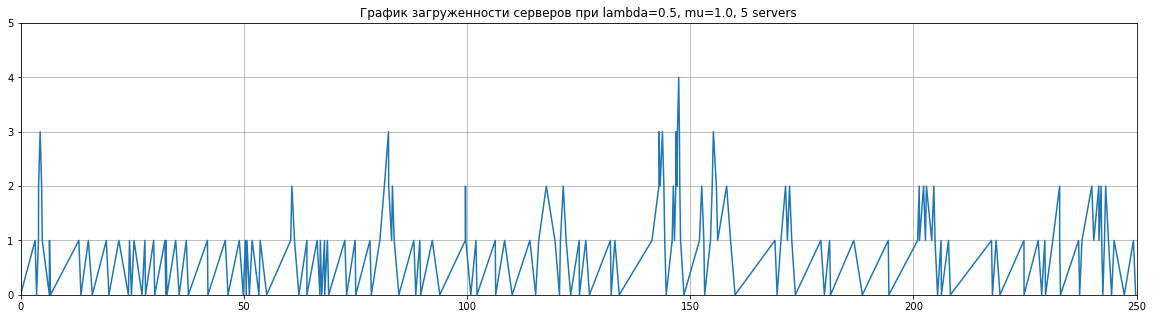

In [126]:
draw_load_plot(2, 1, 5)

### 2. $\lambda=\mu$

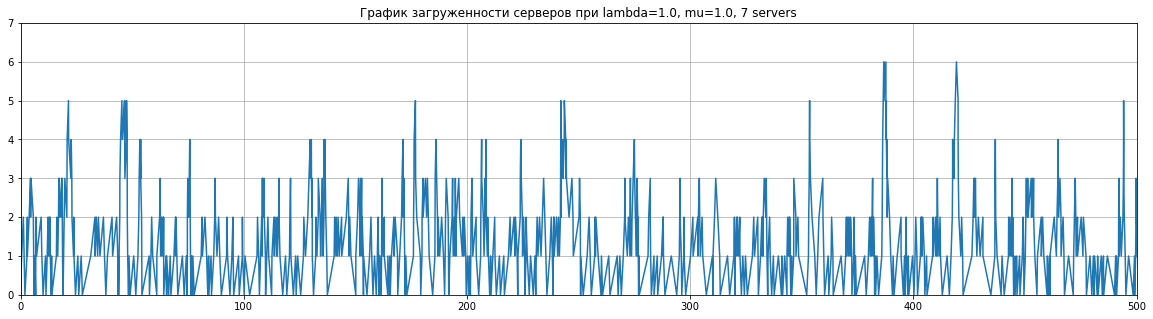

In [127]:
draw_load_plot(1, 1, 7, 500)

### 3. $\lambda>\mu$

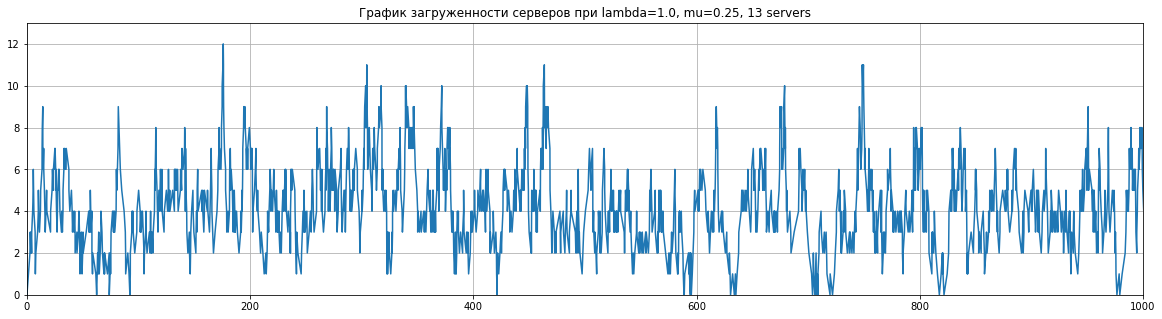

In [128]:
draw_load_plot(1, 4, 13, 1000)

#### Видно, что если при росте $\lambda$ относительно $\mu$ нам требуется больше серверов для песперебойной работы.
#### Посмотрим на графики зависимости некоторых статистик модели от роста $\lambda$

### Вероятность отказа

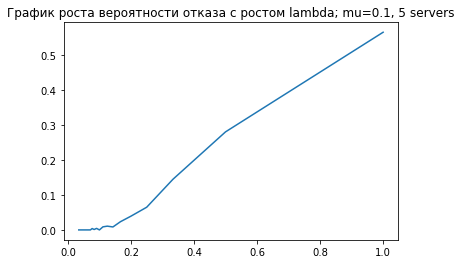

In [92]:
draw_rejection_plot(10, 5)

### Относительная пропускная способность

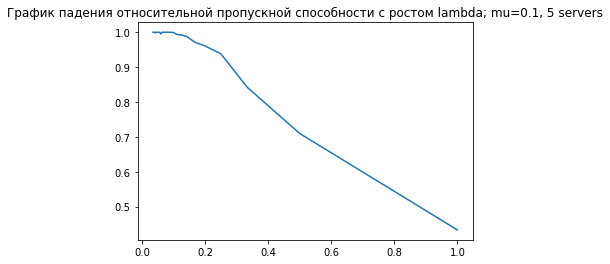

In [94]:
draw_rel_bandwith_plot(10, 5)

#### На этих двух графиках видно, как с ростом $\lambda$ пяти серверов становится недостаточно, и приходится отказывать заявкам.

### Проведем эксперименты с очень большими $\lambda$ относительно $\mu$

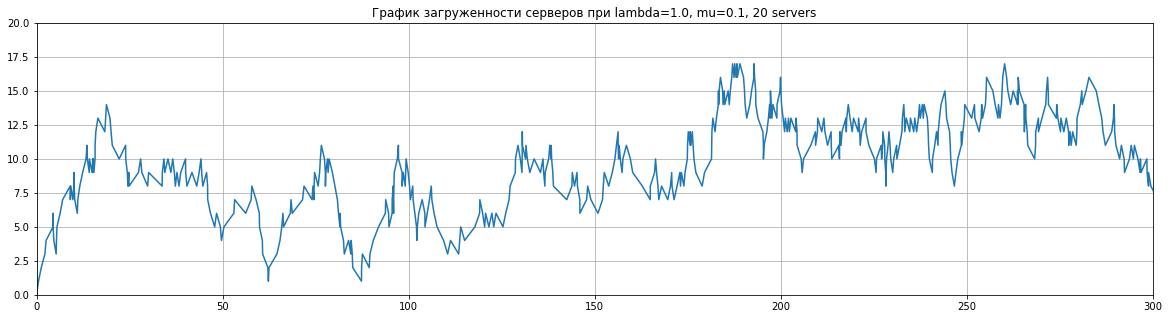

In [135]:
draw_load_plot(1, 10, 20, 300)

# ВЫШЕЛ КИБЕРПАНК 2077, ВСЕ ХОТЯТ ЕГО СКАЧАТЬ, МНОГО ЗАЯВОК!

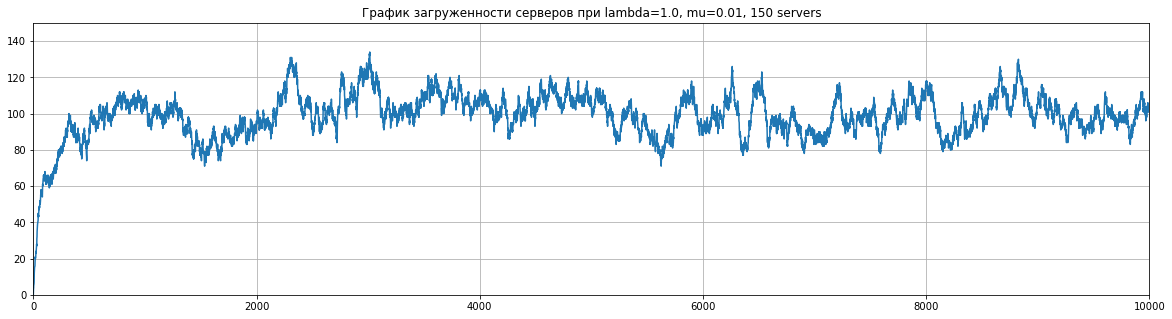

In [146]:
draw_load_plot(1, 100, 150, 10000)

### На наш взгляд, отличающей особенностью данной системы является то, что даже при большой нагрузке и долгом времени обработки систему можно сбалансировать при помощи достаточного количества серверов.
### Если бы мы решали некую бизнес задачу, то зная сколько примерно будет обрабатываться заявка, и спрогнозировав поток пользователей, можно подготовиться, поставить больше серверов и избежать потери денег от упущенных клиентов.

## 4. Проверка модели

In [13]:
def Pi_n(lambda_, mu_, n):
    return pow(lambda_/mu_, n)/math.factorial(n)

In [14]:
def Pi_0(lambda_, mu_, n):
    return 1/(sum([Pi_n(lambda_, mu_, i) for i in range(n+1)]))

In [15]:
def theoretical_stationary_probabilities(lambda_, mu_, n):
    pi0 = Pi_0(lambda_, mu_, n)
    return [Pi_n(lambda_, mu_, i)*pi0 for i in range(n+1)]

In [16]:
def theoretical_average_load(lambda_, mu_, n):
    probs = theoretical_stationary_probabilities(lambda_, mu_, n)
    return sum([server_number*probs[server_number] for server_number in range(len(probs))])

In [17]:
def theoretical_reject_probability(lambda_, mu_, n):
    return pow((lambda_/mu_), n) / math.factorial(n) * Pi_0(lambda_, mu_, n)

In [18]:
def theoretical_absolute_bandwith(lambda_, mu_, n):
    return lambda_*theoretical_relative_bandwith(lambda_, mu_, n)

In [19]:
def theoretical_relative_bandwith(lambda_, mu_, n):
    return 1 - theoretical_reject_probability(lambda_, mu_, n)

#### Сравним экспериментально полученные статистики модели c вычисленными по теоретическим формулам.

### Стационарные вероятности
#### Теоретические:

In [151]:
theoretical_stationary_probabilities(1, 1, 5)

[0.3680981595092025,
 0.3680981595092025,
 0.18404907975460125,
 0.06134969325153375,
 0.015337423312883437,
 0.0030674846625766876]

#### Практические:

In [148]:
res = simulate(1, 1, 5, 1000)
stationary_probabilities(res, 5)

[0.3574157046268002,
 0.3888791471424329,
 0.18373011383539153,
 0.054863727633470624,
 0.011629215862573428,
 0.003215389522848336]

In [149]:
res = simulate(1, 1, 5, 10000)
stationary_probabilities(res, 5)

[0.3678644918564005,
 0.36855451742365225,
 0.1837208947254122,
 0.06188158347173469,
 0.014976191558879989,
 0.0029791088757554463]

#### Видим, что вычисленные вероятности для состояний системы очень близки к теоретическим стационарным вероятностям для фиксированного K
#### Проверим еще несколько значений

In [162]:
theoretical_stationary_probabilities(1/10, 1/3, 5)

[0.7408188010921892,
 0.2222456403276568,
 0.03333684604914852,
 0.0033336846049148534,
 0.000250026345368614,
 1.5001580722116842e-05]

In [163]:
res = simulate(10, 3, 5, 1000)
stationary_probabilities(res, 5)

[0.7650038651041863,
 0.19369730790221976,
 0.02179004878333461,
 0.0007619666395621462,
 0.0,
 0.0]

In [164]:
res = simulate(10, 3, 5, 10000)
stationary_probabilities(res, 5)

[0.738696797173239,
 0.22246595511955997,
 0.033767285346700995,
 0.0023785167629640845,
 0.0007404719663278106,
 0.00018719030578736044]

#### С ростом числа шагов вычисленные вероятности приближаются к теоритическим.

In [172]:
theoretical_stationary_probabilities(1, 1/2, 5)

[0.13761467889908258,
 0.27522935779816515,
 0.27522935779816515,
 0.1834862385321101,
 0.09174311926605505,
 0.03669724770642202]

In [173]:
res = simulate(1, 2, 5, 1000)
stationary_probabilities(res, 5)

[0.12317763376706517,
 0.30149908185851637,
 0.2890210904358018,
 0.18099124305461947,
 0.08505550882613802,
 0.01986179429749284]

In [174]:
res = simulate(1, 2, 5, 10000)
stationary_probabilities(res, 5)

[0.14506813050070794,
 0.27036576027561315,
 0.2753151357120952,
 0.18849859016072393,
 0.09435077713295276,
 0.026398019092730714]

#### Чуть хуже, но все же похоже.

### Проверим также и другие характеристики.

In [198]:
res = simulate(2, 3, 5, 10000)

In [202]:
print(reject_probability(res))
print(theoretical_reject_probability(1/2, 1/3, 5))

0.01562809099901088
0.014183155314305725


In [203]:
print(relative_bandwith(res))
print(theoretical_relative_bandwith(1/2, 1/3, 5))

0.9843719090009891
0.9858168446856943


In [204]:
print(absolute_bandwith(res))
print(theoretical_absolute_bandwith(1/2, 1/3, 5))

0.4970886434734233
0.49290842234284715


In [207]:
print(average_load(res, 1/3))
print(theoretical_average_load(1/2, 1/3, 5))

1.49126593042027
1.4787252670285413


In [ ]:
downtime_probability(res)
theor